In [1]:
import plotly.graph_objects as go
import networkx as nx
import numpy as np
import pandas as pd

In [2]:
DG = nx.read_gpickle("story/test_1hour_July_r0.8_p_0.05.gpickle")

In [3]:
G = DG.to_undirected()
print(f"# of connected components: {nx.number_connected_components(G)}")
ccs_s = pd.Series([len(cc) for cc in nx.connected_components(G)])
print("componet size:")
print(ccs_s.describe())

# of connected components: 381
componet size:
count     381.000000
mean       21.648294
std       293.118608
min         2.000000
25%         3.000000
50%         4.000000
75%         6.000000
max      5685.000000
dtype: float64


In [4]:
df_gdelt_today = pd.read_csv(f"/Volumes/Extreme SSD/gdelt_archive/20220727.csv")
nodes_today = []
for node in DG.nodes():
    if (df_gdelt_today.GLOBALEVENTID == node).any():
        nodes_today.append(node)
print(f"# nodes today: {len(nodes_today)}")

ancesters = []
for node in nodes_today:
    ancesters += nx.ancestors(DG, node)
    
nodes_today = set(nodes_today + ancesters)
print(f"# nodes to show: {len(nodes_today)}")

DG_today = DG.subgraph(nodes_today)

# nodes today: 44
# nodes to show: 359


In [5]:
G = DG_today.to_undirected()
print(f"# of connected components: {nx.number_connected_components(G)}")
ccs_s = pd.Series([len(cc) for cc in nx.connected_components(G)])
print("componet size:")
print(ccs_s.describe())

# of connected components: 23
componet size:
count     23.000000
mean      15.608696
std       29.219762
min        2.000000
25%        3.000000
50%        4.000000
75%       16.000000
max      136.000000
dtype: float64


In [42]:
def draw(graph, prog='neato'):
    pos = nx.nx_agraph.graphviz_layout(graph, prog)
    nx.draw(graph, pos, node_size=5, arrowsize=2.5)

# Visualization Layout Comparison

see https://stackoverflow.com/questions/21978487/improving-python-networkx-graph-layout for details

- conclusion: "neato" and "sfdp" seems better

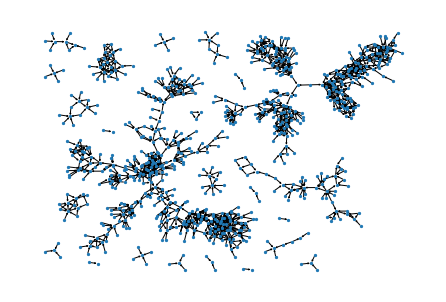

In [50]:
draw(DG_today, prog="neato")

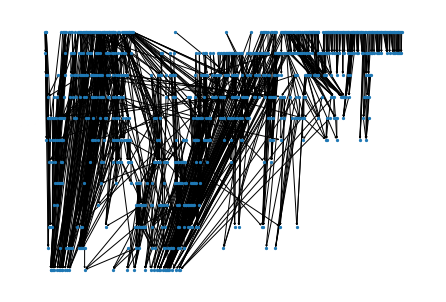

In [17]:
draw(DG, prog="dot")

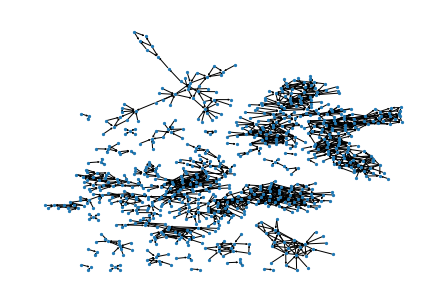

In [43]:
draw(DG_today, prog="fdp")

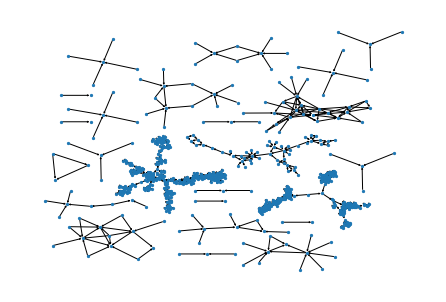

In [44]:
draw(DG_today, prog="sfdp")

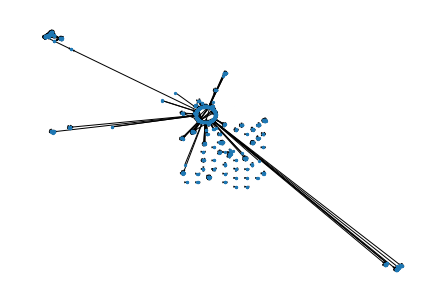

In [21]:
draw(DG, prog="circo")

# Draw via plotly

In [6]:
from pathlib import Path

import datatable as dt

In [7]:
news_title_dir = Path("/Volumes/Extreme SSD/news_archive")

In [8]:
dfs = []
for csv_path in news_title_dir.glob("*.csv"):
    dfs.append(dt.fread(csv_path).to_pandas())
text_df = pd.concat(dfs)

In [9]:
class GraphDrawer:
    def __init__(self, graph_layout="neato", edge_width=0.5, arrow_length=1.1, arrow_width=0.035):
        self.graph_layout = graph_layout
        self.edge_width = edge_width
        self.arrow_length = arrow_length
        self.arrow_width = arrow_width
    
    def draw(self, graph, text_df=None):
        pos = nx.nx_agraph.graphviz_layout(DG, self.graph_layout)
        line_trace, arrow_trace = self.get_edge_trace(graph, pos)
        node_trace = self.get_node_trace(graph, pos, text_df=text_df)
        
        data = [line_trace, arrow_trace, node_trace]
#         data = [arrow_trace]
        fig = go.Figure(data=data,
                        layout=go.Layout(
                            title='<br>Network graph made with Python',
                            titlefont_size=16,
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=20,l=5,r=5,t=40),
                            annotations=[ dict(
                                text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                                showarrow=False,
                                xref="paper", yref="paper",
                                x=0.005, y=-0.002 ) ],
                            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
        return fig
        
        
    def get_edge_trace(self, graph, pos):
        line_trace = self.get_line_trace(graph, pos)
        arrow_trace = self.get_arrow_trace(graph, pos)
        
        return line_trace, arrow_trace
        
    def get_line_trace(self, graph, pos):
        edge_x = []
        edge_y = []
        for edge in graph.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.append(x0)
            edge_x.append(x1)
            edge_x.append(None)
            edge_y.append(y0)
            edge_y.append(y1)
            edge_y.append(None)
        line_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=self.edge_width, color='#888'),
            hoverinfo='none',
            mode='lines')
        return line_trace
    
    def get_arrow_trace(self, graph, pos):
        p0s = []
        p1s = []    
        for edge in graph.edges():
            p0s.append(pos[edge[0]])
            p1s.append(pos[edge[1]])
        p0s = np.array(p0s)
        p1s = np.array(p1s)
        
        v_s = p1s - p0s
        w_s = v_s / np.linalg.norm(v_s, axis=1, keepdims=True)  
        u_s = np.vstack([-w_s[:, 1], w_s[:, 0]]).T * 10 # u orthogonal on  w
#         u_s = np.array([-w_s[1], w_s[0]]) * 10  #u orthogonal on  w

        pms = p1s / 4 * 3 + p0s / 4
        Ps = pms - self.arrow_length * w_s
        Ss = Ps - self.arrow_width * u_s
        Ts = Ps + self.arrow_width * u_s
        
        arrows_x = []
        arrows_y = []
        for P, S, T, pm in zip(Ps, Ss, Ts, pms):
            arrows_x += [S[0], T[0], pm[0], S[0], None]
            arrows_y += [S[1], T[1], pm[1], S[1], None]
        arrow_trace = go.Scatter(x=arrows_x, 
                                 y=arrows_y, 
                                 mode='lines', 
                                 fill='toself', 
                                 fillcolor='blue', 
                                 line_color='blue')
        return arrow_trace
        
    def get_node_trace(self, graph, pos, text_df=None):
        node_x = []
        node_y = []
        for node in graph.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
        
        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers',
            hoverinfo='text',
            marker=dict(
                showscale=True,
                # colorscale options
                #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
                #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
                #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
                colorscale='YlGnBu',
                reversescale=True,
                color=[],
                size=5,
                colorbar=dict(
                    thickness=15,
                    title='Node Connections',
                    xanchor='left',
                    titleside='right'
                ),
            line_width=2))
        
        
#         graph_nodes = list(graph.nodes())
#         node_adjacencies = []
#         node_text = []
#         for node, adjacencies in enumerate(graph.adjacency()):
#             node_adjacencies.append(len(adjacencies[1]))
#             if text_df is not None:
#                 node_text.append(text_df[text_df.global_event_id==graph_nodes[node]].title.values[0])
#             else:
#                 node_text.append('# of connections: '+str(len(adjacencies[1])))
        
        node_in_degree = []
        node_text = []
        for node_idx, node in enumerate(graph.nodes):
            node_in_degree.append(graph.in_degree(node))
            if text_df is not None:
                node_text.append(text_df[text_df.global_event_id==node].title.values[0])
            else:
                node_text.append('# of connections: '+str(len(adjacencies[1])))

        node_trace.marker.color = node_in_degree
        node_trace.text = node_text
        
        return node_trace

        

In [13]:
drawer = GraphDrawer(graph_layout="sfdp", arrow_length=1.1 * 5, arrow_width=0.035 * 5)
fig = drawer.draw(DG_today, text_df=text_df)
fig

In [14]:
DG_today.number_of_nodes()

359

In [23]:
df_gdelt_today = pd.read_csv(f"/Volumes/Extreme SSD/gdelt_archive/20220727.csv")
nodes_today = []
for node in DG.nodes():
    if (df_gdelt_today.GLOBALEVENTID == node).any():
        nodes_today.append(node)
print(f"# nodes today: {len(nodes_today)}")

sub_graphs = []
for node in nodes_today:
    ancestors = nx.ancestors(DG, node)
    sub_graphs.append(DG.subgraph([node] + list(ancestors)))

sub_graphs = sorted(sub_graphs, key=lambda x: x.number_of_nodes(), reverse=True)

# nodes today: 44


In [40]:
drawer = GraphDrawer(graph_layout="sfdp", arrow_length=1.1 * 5, arrow_width=0.035 * 5)
fig = drawer.draw(sub_graphs[1], text_df=text_df)
fig

In [41]:
import numpy as np

In [53]:
from scipy.optimize import linear_sum_assignment

In [85]:
df_gdelt_today = pd.read_csv(f"/Volumes/Extreme SSD/gdelt_archive/20220727.csv")
nodes_today = []
for node in DG.nodes():
    if (df_gdelt_today.GLOBALEVENTID == node).any():
        nodes_today.append(node)
print(f"# nodes today: {len(nodes_today)}")

ancestors_of_nodes = []
for node in nodes_today:
    ancestors_of_nodes.append(set(nx.ancestors(DG, node)))

G = nx.Graph()
# IoUs = np.zeros((len(ancestors_of_nodes), len(ancestors_of_nodes)))
for i, ancestors_i in enumerate(ancestors_of_nodes[:-1]):
    for j, ancestors_j in enumerate(ancestors_of_nodes[i:]):
        intersection = len(ancestors_i & ancestors_j)
        union = len(ancestors_i | ancestors_j)
        if union == 0:
            continue
        j = i + j
        if intersection / union > 0.6:
            G.add_edge(i, j)

print(f"# of connected components: {nx.number_connected_components(G)}")
sub_graphs = []
for cc in nx.connected_components(G):
    ancestors = [ancestors_of_nodes[i] for i in cc]
    nodes = [set([nodes_today[i] for i in cc])]
    sub_graphs.append(DG.subgraph(set.union(*(ancestors + nodes))))

sub_graphs = sorted(sub_graphs, key=lambda x: x.number_of_nodes(), reverse=True)

# nodes today: 44
# of connected components: 27


In [111]:
drawer = GraphDrawer(graph_layout="sfdp", arrow_length=1.1, arrow_width=0.035)
fig = drawer.draw(sub_graphs[10], text_df=text_df)
fig